In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.mstats import gmean

In [3]:
def extract_metric_evolution(path, x_key, y_key):
    """Extract the series of values from file."""
    df = pd.read_csv(path)
    epochs = sorted(df['epoch'].unique())
    particles = sorted(df['particle'].unique())
    xs = [df[df['epoch']==epoch][x_key] for epoch in epochs]
    ys = [df[df['epoch']==epoch][y_key] for epoch in epochs]
    assert np.shape(xs) == (len(epochs), len(particles))
    assert np.shape(ys) == (len(epochs), len(particles))
    return np.asarray(xs), np.asarray(ys)

In [4]:
def rescale_linear(xs, yl, yh):
    """Rescale values linearly between [yl, yh]."""
    xl = min(xs)
    xh = max(xs)
    slope = float(yh - yl) / (xh - xl)
    intercept = yh - xh * slope
    return slope* xs + intercept

In [5]:
def unscale_linear(xs, yl, yh, xl, xh):
    """Rescale values linearly between [xl, xh]."""
    slope = float(yh - yl) / (xh - xl)
    intercept = yh - xh * slope
    return (xs - intercept) / slope

In [6]:
paths = [
    ('Venture' , '../resources/reports/stamp@20181102-155157_shortname@vs-euHdZTNmNT_ntest@20_iters@5_epochs@200_schedule@constant_seed@1387012777.merged.report.csv'),
    ('Gen (Dyanmic)'     , '../resources/reports/stamp@20181109-132239_shortname@lightweight-pZadKE_ntest@20_iters@5_epochs@400_schedule@constant_seed@2840552220.merged.report.csv'),
    ('Gen (Dynamic + recurse)'        , '../resources/reports/stamp@20181109-125618_shortname@incremental-mIzAK_ntest@20_iters@5_epochs@400_schedule@constant_seed@3567539547.merged.report.csv'),
    ('Julia' , '../resources/reports/stamp@20181104-143323_shortname@handcoded-iZaMk_ntest@20_iters@5_epochs@400_schedule@constant_seed@1788702245.merged.report.csv'),
]

In [7]:
def plot_evolution_one(runtimes, metrics, label, color, ax):
    runtimes = runtimes[1:]
    metrics = metrics[1:]
    # Computing metrics to plot.
    x_runtime = np.cumsum(np.median(runtimes, axis=1))
    y_metric_median = np.mean(metrics, axis=1)
    y_metric_high = np.percentile(metrics, 75, axis=1)
    y_metric_low = np.percentile(metrics, 25, axis=1)
    # XXX A tinge of serious hackery.
    if label == 'Gen (naive)':
        x_runtime = x_runtime[:-100]
        y_metric_median = y_metric_median[:-100]
    # Plot.
    ax.errorbar(
        x_runtime[::20],
        y_metric_median[::20],
        # yerr=[y_metric_median-y_metric_low, y_metric_high-y_metric_median],
        fmt='-.', 
        markersize=5,
        label=label,
        color=color)
    return ax

In [8]:
metric = 'rmse'

In [9]:
import matplotlib

Plot runtime vs. accuracy

/scratch/fsaad/p3/lib/python3.5/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


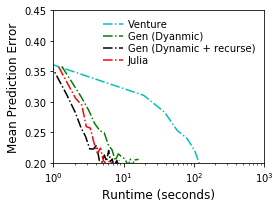

In [10]:
fig, ax = plt.subplots()
colors = ['c', 'g', 'k', 'r']
for i, (method, path) in enumerate(paths):
    runtimes, metrics = extract_metric_evolution(path, 'runtime', metric)
    ax = plot_evolution_one(runtimes, metrics, method, colors[i], ax)

# ax.set_title('Runtime vs. Accuracy on Airline Data', fontsize=13)
ax.set_ylabel('Mean Prediction Error', fontsize=12)
ax.set_xlabel('Runtime (seconds)', fontsize=12)
ax.legend(loc='upper right', framealpha=0, labelspacing=.2, handletextpad=.5)
# ax.grid(which='both', linestyle='-', linewidth=1, color='gray', alpha=.2)
ax.set_xscale('log')
ax.set_xlim([10**-0, 10**3])
ax.set_ylim([0.2, 0.45])
fig.set_facecolor('white')
fig.set_tight_layout(True)
fig.set_size_inches(4,3)

In [11]:
fig.savefig('airline-gen-venturescript-runtime-rmse.pdf')

Plot observed and forecasted data

In [12]:
import json

In [13]:
fname = '../resources/results/stamp@20181102-155414_shortname@vs-euHdMzVkOW_ntest@20_iters@5_epochs@200_schedule@constant_seed@725158738.json'
with open(fname, 'r') as f:
    results = json.load(f)

In [14]:
predictions = results['statistics'][-1]['predictions_held_out']

In [15]:
(x_min, y_min) = (1.949041666666666742e+03, 1.12e+02)
(x_max, y_max) = (1.960958333333333258e+03, 4.32e+02)

In [16]:
xs_train = unscale_linear(np.array(results['xs_train']), 0, 1, x_min, x_max)
ys_train = unscale_linear(np.array(results['ys_train']), -1, 1, y_min, y_max)
xs_test = unscale_linear(np.array(results['xs_test']), 0, 1, x_min, x_max)
ys_test = unscale_linear(np.array(results['ys_test']), -1, 1, y_min, y_max)
predictions = unscale_linear(np.array(predictions), -1, 1, y_min, y_max)

In [17]:
from matplotlib.ticker import MaxNLocator
MaxNLocator?

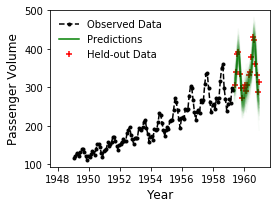

In [18]:
fig, ax = plt.subplots()
ax.plot(xs_train, ys_train, marker='.', linestyle='--', color='k', label='Observed Data')
for p in predictions:
    ax.plot(xs_test, p, linestyle='-', color='g', alpha=.025)
ax.plot([], [], color='g', label='Predictions')
ax.scatter(xs_test, ys_test, marker='+', color='r', s=30, label='Held-out Data')
ax.legend(framealpha=0, loc='upper left')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Passenger Volume', fontsize=12)
# ax.set_title('Airline Dataset', fontsize=13)
ax.set_xlim([1947.5, None])
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(steps=[2], integer=True))
fig.set_tight_layout(True)
fig.set_size_inches(4, 3)

In [19]:
fig.savefig('airline-raw-data.pdf')

In [20]:
def report_runtime(runtimes, method):
    runtimes = runtimes[1:]
    runtimes_total = np.cumsum(runtimes, axis=0)
    median = np.median(runtimes_total, axis=1)[-1]
    upper = np.percentile(runtimes_total, 25, axis=1)[-1]
    lower = np.percentile(runtimes_total, 75, axis=1)[-1]
    error = np.mean([abs(median-upper), abs(median-lower)])
    with open('gp-runtime', 'a') as f:
        print('%s: %1.2f (+- %1.2f)' % (method, median/2, error/2), file=f)

In [21]:
!rm -f gp-runtime && touch gp-runtime
for method, path in paths:
    runtimes, metrics = extract_metric_evolution(path, 'runtime', metric)
    report_runtime(runtimes, method)

In [22]:
!rm -f gp-loc && touch gp-loc
!wc -l ../resources/gp_model_0.vnts >> gp-loc
!wc -l ../lightweight.jl >> gp-loc
!wc -l ../incremental.jl >> gp-loc
!wc -l ../handcoded.jl >> gp-loc

In [23]:
!cat gp-loc

60 ../resources/gp_model_0.vnts
94 ../lightweight.jl
233 ../incremental.jl
442 ../handcoded.jl
